In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy import stats

In [22]:
def load_data():
    customers_df = pd.read_csv('Customers.csv')
    products_df = pd.read_csv('Products.csv')
    transactions_df = pd.read_csv('Transactions.csv')

    # Convert date columns to datetime
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    return customers_df, products_df, transactions_df

### Function: `advanced_customer_analysis`

This function performs advanced analysis on customer behavior and transactions. It provides insights into cohort retention, customer tenure, and purchase patterns.

#### Steps are:
1. **Cohort Analysis**:
   - Assigns customers to cohorts based on their signup month (`CohortMonth`).
   - Tracks transaction months (`TransactionMonth`) for customer behavior analysis.

2. **Customer Retention**:
   - Calculates the number of active customers for each cohort and month since signup.

3. **Average Transaction Value by Tenure**:
   - Computes the average transaction value for customers grouped by their tenure in months.

4. **Purchase Frequency**:
   - Summarizes purchase behavior for each customer, including:
     - Total number of transactions (`NumTransactions`).
     - Total money spent (`TotalSpent`).
     - Customer lifespan in days (`CustomerLifespan`).
   - Calculates average transactions per month.

#### Output:
- **`cohort_retention`**: Tracks customer retention rates by cohort over time.
- **`avg_value_by_tenure`**: Shows average spending based on customer tenure.
- **`purchase_frequency`**: Details customer-level purchase behavior metrics, including transaction frequency and average spending.


In [23]:
def advanced_customer_analysis(customers_df, transactions_df):
    # Customer cohort analysis
    customers_df['CohortMonth'] = customers_df['SignupDate'].dt.to_period('M')
    transactions_df['TransactionMonth'] = transactions_df['TransactionDate'].dt.to_period('M')

    # Merge for customer behavior analysis
    customer_behavior = transactions_df.merge(customers_df, on='CustomerID')

    # Calculate months between signup and transaction
    customer_behavior['MonthsActive'] = ((customer_behavior['TransactionDate'] -
                                        customer_behavior['SignupDate']).dt.days / 30).astype(int)

    # Customer retention by cohort
    cohort_retention = customer_behavior.groupby(['CohortMonth', 'MonthsActive'])['CustomerID'].nunique()

    # Average transaction value by customer tenure
    avg_value_by_tenure = customer_behavior.groupby('MonthsActive')['TotalValue'].mean()

    # Frequency of purchases
    purchase_frequency = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': 'sum',
        'TransactionDate': lambda x: (x.max() - x.min()).days
    }).rename(columns={'TransactionID': 'NumTransactions',
                      'TotalValue': 'TotalSpent',
                      'TransactionDate': 'CustomerLifespan'})

    # Add average transaction frequency (transactions per month)
    purchase_frequency['TransactionsPerMonth'] = (purchase_frequency['NumTransactions'] /
                                                (purchase_frequency['CustomerLifespan'] / 30))

    return cohort_retention, avg_value_by_tenure, purchase_frequency

### Function: `product_performance_analysis`

This function analyzes product and category performance using transaction and product data.

####Outputs are:
1. **Product Metrics**:
   - Total sales value, quantity sold, and transaction count for each product.
   - Average order value per product.

2. **Category Metrics**:
   - Total sales, quantity, unique transactions, and customers per category.
   - Estimated profit (30% margin assumption).

3. **Product Purchase Patterns**:
   - Unique sales days, customer count, and purchase quantity statistics (sum, mean, std) per product and category.


In [24]:
def product_performance_analysis(transactions_df, products_df):
    # Merge transactions with products
    product_sales = transactions_df.merge(products_df, on='ProductID')

    # Product performance metrics
    product_metrics = product_sales.groupby('ProductID').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum',
        'TransactionID': 'count'
    }).rename(columns={'TransactionID': 'NumTransactions'})

    # Calculate average order value per product
    product_metrics['AvgOrderValue'] = product_metrics['TotalValue'] / product_metrics['NumTransactions']

    # Product category performance
    category_metrics = product_sales.groupby('Category').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum',
        'TransactionID': 'nunique',
        'CustomerID': 'nunique'
    })

    # Calculate category profit margins (assuming a default margin of 30%)
    category_metrics['EstimatedProfit'] = category_metrics['TotalValue'] * 0.3

    # Product purchase patterns
    product_patterns = product_sales.groupby(['ProductID', 'Category']).agg({
        'TransactionDate': lambda x: x.nunique(),  # Number of unique days with sales
        'CustomerID': 'nunique',  # Number of unique customers
        'Quantity': ['sum', 'mean', 'std']  # Purchase quantity statistics
    })

    return product_metrics, category_metrics, product_patterns

### This Function: `regional_performance_analysis`

This function evaluates regional performance and growth using transaction and customer data.

#### Outputs are:
1. **Regional Metrics**:
   - Total sales, average sales, transaction count, unique customers, and transactions per customer for each region.
   - Average order value per region.

2. **Regional Growth**:
   - Monthly total sales trends by region.
   - Percentage growth in sales across months.


In [25]:
def regional_performance_analysis(transactions_df, customers_df):

    regional_sales = transactions_df.merge(customers_df, on='CustomerID')


    regional_metrics = regional_sales.groupby('Region').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'CustomerID': 'nunique',
        'TransactionID': 'nunique'
    })


    regional_metrics['AvgOrderValue'] = (regional_metrics[('TotalValue', 'sum')] /
                                       regional_metrics[('TransactionID', 'nunique')])
    regional_metrics['TransactionsPerCustomer'] = (regional_metrics[('TransactionID', 'nunique')] /
                                                 regional_metrics[('CustomerID', 'nunique')])


    regional_sales['YearMonth'] = regional_sales['TransactionDate'].dt.to_period('M')
    regional_growth = regional_sales.groupby(['Region', 'YearMonth'])['TotalValue'].sum().unstack()
    regional_growth_pct = regional_growth.pct_change(axis=1)

    return regional_metrics, regional_growth, regional_growth_pct

### working of below Function: `customer_segmentation_analysis`

This function segments customers based on RFM (Recency, Frequency, Monetary) analysis to categorize them into different segments.

#### Key method ar:
1. **RFM Calculation**:
   - Recency: Days since last transaction.
   - Frequency: Number of transactions.
   - Monetary: Total spending.

2. **Customer Segmentation**:
   - RFM scores are assigned using quantiles (1 to 5).
   - Customer segments are defined based on RFM scores, including:
     - **Champions**: Highly engaged customers.
     - **Loyal Customers**: Frequent and valuable customers.
     - **Active Customers**: Engaged customers.
     - **Lost Customers**: Inactive customers.
     - **At Risk**: Customers with declining activity.


In [27]:
def customer_segmentation_analysis(transactions_df, customers_df):

    latest_date = transactions_df['TransactionDate'].max()

    rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (latest_date - x.max()).days,
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).rename(columns={
        'TransactionDate': 'Recency',
        'TransactionID': 'Frequency',
        'TotalValue': 'MonetaryValue'
    })

    # Creating RFM segments
    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=5, labels=[1, 2, 3, 4, 5])
    rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], q=5, labels=[1, 2, 3, 4, 5])

    rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


    def segment_customers(row):
        if row['R_Score'] == 5 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
            return 'Champions'
        elif row['R_Score'] >= 4 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return 'Loyal Customers'
        elif row['R_Score'] >= 3:
            return 'Active Customers'
        elif row['R_Score'] == 1:
            return 'Lost Customers'
        else:
            return 'At Risk'

    rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

    return rfm

In [28]:
def seasonal_analysis(transactions_df):

    transactions_df['Year'] = transactions_df['TransactionDate'].dt.year
    transactions_df['Month'] = transactions_df['TransactionDate'].dt.month
    transactions_df['DayOfWeek'] = transactions_df['TransactionDate'].dt.dayofweek


    monthly_patterns = transactions_df.groupby('Month').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean']
    })


    daily_patterns = transactions_df.groupby('DayOfWeek').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean']
    })


    yearly_growth = transactions_df.groupby('Year')['TotalValue'].sum().pct_change()

    return monthly_patterns, daily_patterns, yearly_growth

In [29]:
def plot_key_insights(customers_df, products_df, transactions_df, rfm):
    plt.figure(figsize=(20, 15))

    # Plot 1: Customer Segments Distribution
    plt.subplot(3, 2, 1)
    sns.countplot(data=rfm, x='Customer_Segment')
    plt.title('Distribution of Customer Segments')
    plt.xticks(rotation=45)

    # Plot 2: Monthly Sales Trend
    plt.subplot(3, 2, 2)
    monthly_sales = transactions_df.groupby(transactions_df['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()
    monthly_sales.plot()
    plt.title('Monthly Sales Trend')

    # Plot 3: Regional Performance
    plt.subplot(3, 2, 3)
    regional_sales = transactions_df.merge(customers_df, on='CustomerID').groupby('Region')['TotalValue'].sum()
    regional_sales.plot(kind='bar')
    plt.title('Sales by Region')

    # Plot 4: Category Performance
    plt.subplot(3, 2, 4)
    category_sales = transactions_df.merge(products_df, on='ProductID').groupby('Category')['TotalValue'].sum()
    category_sales.plot(kind='bar')
    plt.title('Sales by Category')
    plt.xticks(rotation=45)

    # Plot 5: Customer Lifetime Value Distribution
    plt.subplot(3, 2, 5)
    customer_ltv = transactions_df.groupby('CustomerID')['TotalValue'].sum()
    sns.histplot(customer_ltv, bins=50)
    plt.title('Customer Lifetime Value Distribution')

    # Plot 6: Purchase Frequency Distribution
    plt.subplot(3, 2, 6)
    purchase_freq = transactions_df.groupby('CustomerID').size()
    sns.histplot(purchase_freq, bins=50)
    plt.title('Purchase Frequency Distribution')

    plt.tight_layout()
    plt.show()


In [30]:
def main():
    # Load data
    customers_df, products_df, transactions_df = load_data()


    cohort_retention, avg_value_by_tenure, purchase_frequency = advanced_customer_analysis(
        customers_df, transactions_df
    )

    product_metrics, category_metrics, product_patterns = product_performance_analysis(
        transactions_df, products_df
    )

    regional_metrics, regional_growth, regional_growth_pct = regional_performance_analysis(
        transactions_df, customers_df
    )

    rfm = customer_segmentation_analysis(transactions_df, customers_df)

    monthly_patterns, daily_patterns, yearly_growth = seasonal_analysis(transactions_df)


    plot_key_insights(customers_df, products_df, transactions_df, rfm)

    return {
        'customer_analysis': {
            'cohort_retention': cohort_retention,
            'value_by_tenure': avg_value_by_tenure,
            'purchase_frequency': purchase_frequency
        },
        'product_analysis': {
            'product_metrics': product_metrics,
            'category_metrics': category_metrics,
            'product_patterns': product_patterns
        },
        'regional_analysis': {
            'regional_metrics': regional_metrics,
            'regional_growth': regional_growth,
            'regional_growth_pct': regional_growth_pct
        },
        'customer_segments': rfm,
        'seasonal_analysis': {
            'monthly_patterns': monthly_patterns,
            'daily_patterns': daily_patterns,
            'yearly_growth': yearly_growth
        }
    }



<ipython-input-25-dae005a14603>:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  regional_growth_pct = regional_growth.pct_change(axis=1)


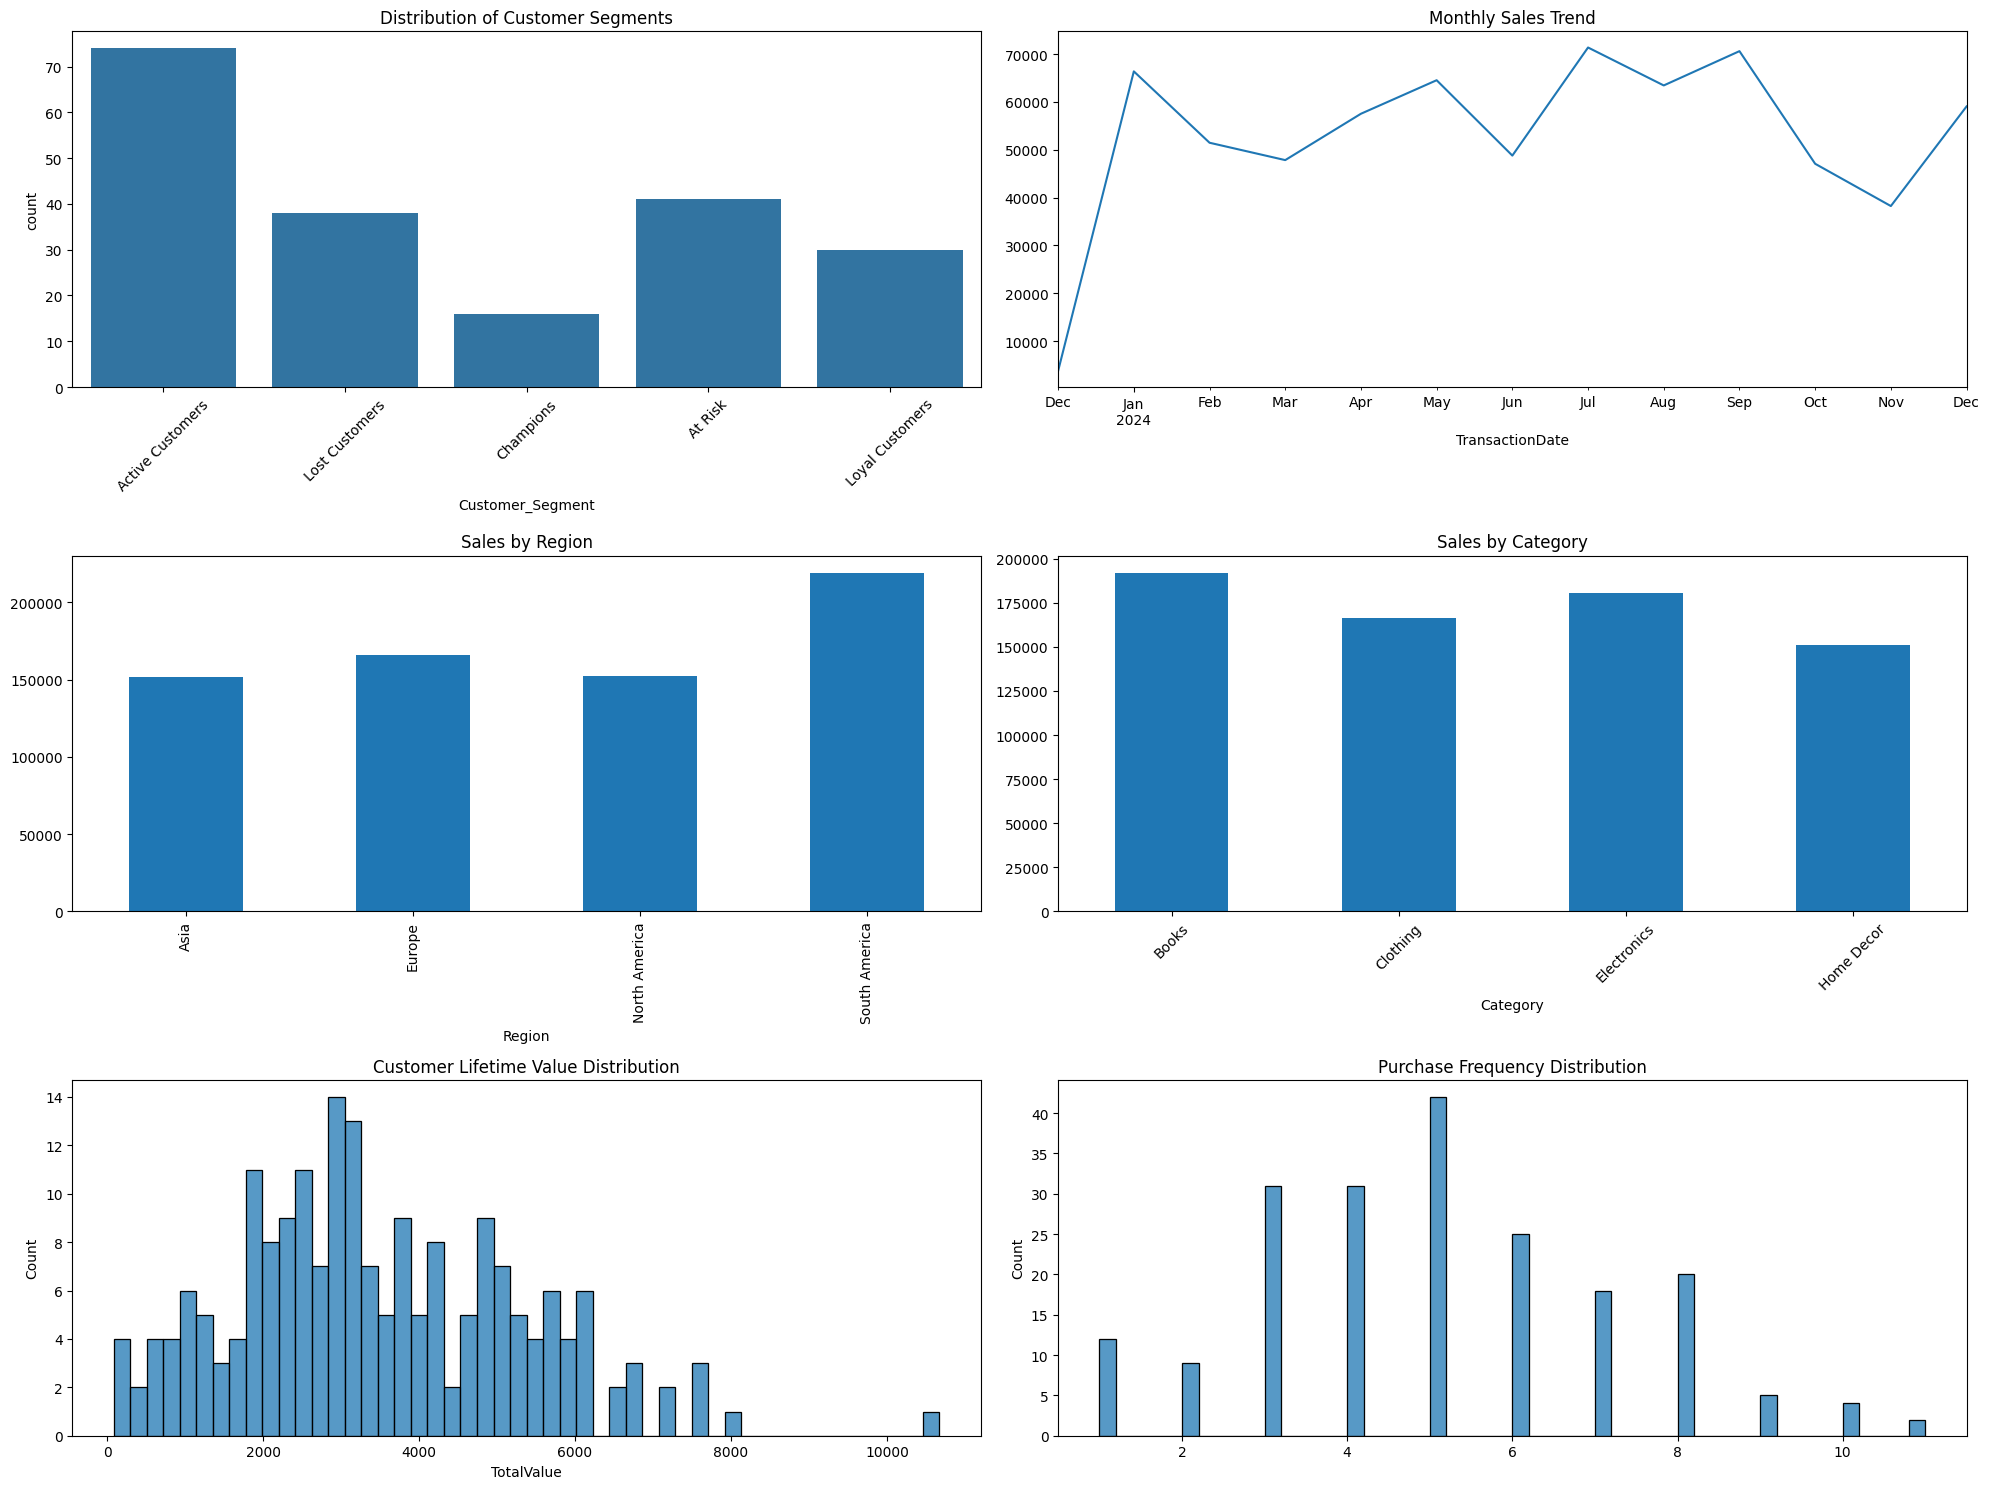

In [31]:
if __name__ == "__main__":
    results = main()

# In-Depth Analysis of Customer Spend, Regional Product Affinities, and Price Sensitivity

In [32]:
def calculate_customer_metrics(transactions_df, customers_df):
    """Calculate detailed customer-related metrics"""

    customer_life = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (x.max() - x.min()).days,
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    customer_life.columns = ['CustomerID', 'LifetimeDays', 'TotalSpend', 'TransactionCount']
    customer_life['AverageDailySpend'] = customer_life['TotalSpend'] / customer_life['LifetimeDays'].replace(0, 1)
    customer_life['AverageTransactionValue'] = customer_life['TotalSpend'] / customer_life['TransactionCount']

    spend_percentiles = customer_life['TotalSpend'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    print("\nCustomer Spend Percentiles:")
    print(spend_percentiles)


    customer_purchases = transactions_df.groupby('CustomerID')['TransactionDate'].agg(list)
    purchase_intervals = customer_purchases.apply(lambda x: np.diff(sorted(x))).explode()
    purchase_intervals = pd.Series(purchase_intervals.dt.days)

    print("\nPurchase Interval Statistics (days):")
    print(purchase_intervals.describe())

    return customer_life

In [33]:
def analyze_product_combinations(transactions_df, products_df):
    """Analyze commonly purchased product combinations"""


    transaction_products = transactions_df.merge(products_df[['ProductID', 'Category']], on='ProductID')


    multi_category_transactions = transaction_products.groupby('TransactionID')['Category'].agg(list)
    category_combinations = multi_category_transactions[multi_category_transactions.apply(len) > 1]

    # Count common category pairs
    pair_counts = {}
    for categories in category_combinations:
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                pair = tuple(sorted([categories[i], categories[j]]))
                pair_counts[pair] = pair_counts.get(pair, 0) + 1

    top_pairs = pd.Series(pair_counts).sort_values(ascending=False).head(10)
    print("\nTop 10 Category Combinations:")
    print(top_pairs)

    return pair_counts

In [55]:

def analyze_regional_product_affinity(transactions_df, customers_df, products_df):
    """Analyze product category preferences by region"""


    regional_prefs = transactions_df.merge(customers_df[['CustomerID', 'Region']], on='CustomerID')\
                                  .merge(products_df[['ProductID', 'Category']], on='ProductID')

    regional_category_sales = regional_prefs.groupby(['Region', 'Category'])['TotalValue'].sum().unstack()
    regional_category_share = regional_category_sales.div(regional_category_sales.sum(axis=1), axis=0) * 100

    print("\nCategory Share by Region (%):")
    print(regional_category_share.round(2))


    global_category_share = regional_prefs.groupby('Category')['TotalValue'].sum() / \
                          regional_prefs['TotalValue'].sum() * 100

    category_preference_index = regional_category_share.div(global_category_share, axis=1) * 100

    print("\nCategory Preference Index (100 = Global Average):")
    print(category_preference_index.round(2))

    return regional_category_share, category_preference_index


In [57]:
def analyze_cohort_retention_fixed(transactions_df, customers_df):
    """Analyze customer retention with proper handling of NaN values."""


    df = transactions_df.merge(customers_df[['CustomerID', 'SignupDate']], on='CustomerID')


    df['CohortMonth'] = df['SignupDate'].dt.to_period('M')
    df['TransactionMonth'] = df['TransactionDate'].dt.to_period('M')


    df['MonthsActive'] = ((df['TransactionMonth'].astype('datetime64[M]') -
                          df['CohortMonth'].astype('datetime64[M]')).dt.n)


    cohort_data = df.groupby(['CohortMonth', 'MonthsActive'])['CustomerID'].nunique().reset_index()


    cohort_sizes = df.groupby('CohortMonth')['CustomerID'].nunique()


    cohort_retention = cohort_data.pivot(index='CohortMonth',
                                         columns='MonthsActive',
                                         values='CustomerID')

    # Calculate retention rates
    retention_rates = cohort_retention.div(cohort_sizes, axis=0) * 100

    # Handle NaN values: Fill missing months with 0% retention
    retention_rates = retention_rates.fillna(0).round(2)


    min_months = 3
    retention_rates = retention_rates[retention_rates.count(axis=1) >= min_months]

    # Check for any remaining NaN values (should not exist after fillna and filtering)
    assert retention_rates.isna().sum().sum() == 0, "NaN values still present after cleaning!"

    print("\nCohort Retention Rates (%):")
    print(retention_rates)

    return retention_rates


def analyze_price_sensitivity_fixed(transactions_df, products_df):
    """Analyze price sensitivity with proper warning handling"""


    price_analysis = transactions_df.copy()
    price_analysis['ActualPrice'] = price_analysis['TotalValue'] / price_analysis['Quantity']


    price_analysis = price_analysis.merge(products_df[['ProductID', 'Category']], on='ProductID')

    price_analysis = price_analysis[
        (price_analysis['ActualPrice'] > 0) &
        (price_analysis['ActualPrice'] < price_analysis['ActualPrice'].quantile(0.99))
    ]

    def analyze_category_price_sensitivity(data):
        """Analyze price sensitivity for a category"""
        try:
            price_quartiles = pd.qcut(data['ActualPrice'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            quantity_stats = data.groupby(price_quartiles, observed=True)['Quantity'].agg([
                'mean',
                'count',
                'sum'
            ]).round(2)


            price_ranges = pd.qcut(data['ActualPrice'], 4)
            quantity_stats['price_range'] = price_ranges.apply(lambda x: f"${x.left:.2f}-${x.right:.2f}").unique()

            return quantity_stats
        except ValueError:

            return pd.DataFrame()


    category_sensitivity = {}
    for category in price_analysis['Category'].unique():
        category_data = price_analysis[price_analysis['Category'] == category]
        sensitivity = analyze_category_price_sensitivity(category_data)
        if not sensitivity.empty:
            category_sensitivity[category] = sensitivity


    overall_sensitivity = analyze_category_price_sensitivity(price_analysis)

    print("\nPrice Sensitivity Analysis by Category:")
    for category, stats in category_sensitivity.items():
        print(f"\n{category}:")
        print(stats)

    print("\nOverall Price Sensitivity:")
    print(overall_sensitivity)

    return category_sensitivity, overall_sensitivity


In [61]:

def main_analysis():

    try:
        previous_results = results
        customers_df = pd.read_csv('Customers.csv')
        products_df = pd.read_csv('Products.csv')
        transactions_df = pd.read_csv('Transactions.csv')


        customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
        transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    except NameError:
        print("Loading data from CSV files...")
        customers_df = pd.read_csv('Customers.csv')
        products_df = pd.read_csv('Products.csv')
        transactions_df = pd.read_csv('Transactions.csv')


        customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
        transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


    print("=== Detailed Customer Metrics ===")
    customer_metrics = calculate_customer_metrics(transactions_df, customers_df)

    print("\n=== Product Combination Analysis ===")
    product_combinations = analyze_product_combinations(transactions_df, products_df)

    # print("\n=== Customer Growth Analysis ===")
    # growth_metrics = analyze_customer_growth(transactions_df, customers_df)

    print("\n=== Regional Product Affinity Analysis ===")
    regional_affinity = analyze_regional_product_affinity(transactions_df, customers_df, products_df)

    print("\n=== Price Sensitivity Analysis ===")
    price_sensitivity_results = analyze_price_sensitivity_fixed(transactions_df, products_df)

    return {
        'customer_metrics': customer_metrics,
        'product_combinations': product_combinations,
        # 'growth_metrics': growth_metrics,
        'regional_affinity': regional_affinity,
        # 'price_sensitivity': price_sensitivity
    }


detailed_results = main_analysis()

=== Detailed Customer Metrics ===

Customer Spend Percentiles:
0.25    2162.0400
0.50    3137.6600
0.75    4770.2250
0.90    5869.2600
0.95    6614.6170
0.99    7671.2338
Name: TotalSpend, dtype: float64

Purchase Interval Statistics (days):
count    801.000000
mean      55.377029
std       51.014975
min        0.000000
25%       16.000000
50%       40.000000
75%       81.000000
max      295.000000
Name: TransactionDate, dtype: float64

=== Product Combination Analysis ===

Top 10 Category Combinations:
Series([], dtype: object)

=== Regional Product Affinity Analysis ===

Category Share by Region (%):
Category       Books  Clothing  Electronics  Home Decor
Region                                                 
Asia           21.78     32.45        23.45       22.32
Europe         28.55     21.86        25.00       24.60
North America  27.45     24.97        29.36       18.22
South America  31.80     19.35        26.83       22.02

Category Preference Index (100 = Global Average):
Cat

# **Detailed Customer Metrics**

### **Customer Spend Percentiles**
The customer spend percentiles indicate the distribution of total spending across customers. The key percentiles are:

- **25th Percentile**: $2162.04
- **50th Percentile (Median)**: $3137.66
- **75th Percentile**: $4770.23
- **90th Percentile**: $5869.26
- **95th Percentile**: $6614.62
- **99th Percentile**: $7671.23

### **Purchase Interval Statistics (days)**
This shows the time between consecutive purchases made by customers:

- **Count**: 801 intervals
- **Mean**: 55.38 days
- **Standard Deviation**: 51.01 days
- **Minimum**: 0 days
- **25th Percentile**: 16 days
- **50th Percentile (Median)**: 40 days
- **75th Percentile**: 81 days
- **Maximum**: 295 days

---
